In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
# df = pd.read_csv('/content/drive/MyDrive/Colab Uploads/DiabetesDataSurveyBy_RIR.csv')
df = pd.read_csv('DiabetesDataSurveyBy_RIR.csv')
df.head()


,age,gender,pluse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,cardiovascular_disease,stroke,output
0,65,male,54,169,108,135.72,160.000,54.5,21.289062,0,0,0,0
1,32,female,82,129,86,252.00,180.000,60.0,18.518519,0,0,0,1
2,57,female,76,120,80,280.00,155.448,58.0,24.002568,1,1,0,1
3,60,male,73,129,86,105.48,165.000,61.3,22.516070,0,0,0,1
4,55,female,63,162,89,125.28,150.000,62.1,27.600000,0,0,0,1


In [ ]:
df.info()
df.describe()
df.isnull().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1829 non-null   int64  
 1   gender                  1829 non-null   object 
 2   pluse_rate              1829 non-null   int64  
 3   systolic_bp             1829 non-null   int64  
 4   diastolic_bp            1829 non-null   int64  
 5   glucose                 1829 non-null   float64
 6   height                  1829 non-null   float64
 7   weight                  1829 non-null   float64
 8   bmi                     1829 non-null   float64
 9   family_diabetes         1829 non-null   int64  
 10  cardiovascular_disease  1829 non-null   int64  
 11  stroke                  1829 non-null   int64  
 12  output                  1829 non-null   int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 185.9+ KB


,0
age,0
gender,0
pluse_rate,0
systolic_bp,0
diastolic_bp,0
glucose,0
height,0
weight,0
bmi,0
family_diabetes,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

df['gender'] = LabelEncoder().fit_transform(df['gender'].str.strip().str.lower())  # male=1, female=0


In [ ]:
df['output'].value_counts(normalize=True)


,proportion
output,
1,0.531985
0,0.468015


In [ ]:
# Show count of each class
print("Count of output classes:")
print(df['output'].value_counts())

# Show total number of samples
print("\nTotal samples in dataset:", len(df))


Count of output classes:
output
1    973
0    856
Name: count, dtype: int64

Total samples in dataset: 1829


In [ ]:
df['gender'] = LabelEncoder().fit_transform(df['gender'])

# Feature engineering: pulse pressure = systolic - diastolic
df['pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']

In [ ]:
df['bmi_glucose'] = df['bmi'] * df['glucose']
df['age_glucose'] = df['age'] * df['glucose']


In [ ]:
X = df.drop('output', axis=1)
y = df['output']



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
# Import libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

# Split train into training and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert to XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Set parameters with regularization
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'gpu_hist',         # GPU acceleration
    'predictor': 'gpu_predictor',
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 3,
    'seed': 42
}

# Train model with early stopping
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=20,
    verbose_eval=True
)

# Predict on test set
y_pred_proba = booster.predict(dtest)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluation
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# (Optional) Training accuracy (on full train set if needed)
dtrain_full = xgb.DMatrix(X_train, label=y_train)
train_pred = (booster.predict(dtrain_full) >= 0.5).astype(int)
train_acc = accuracy_score(y_train, train_pred)
print("Train Accuracy:", train_acc)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	Validation-logloss:0.66561
[1]	Validation-logloss:0.64384
[2]	Validation-logloss:0.62182
[3]	Validation-logloss:0.60412
[4]	Validation-logloss:0.58591
[5]	Validation-logloss:0.56884
[6]	Validation-logloss:0.55457
[7]	Validation-logloss:0.54062
[8]	Validation-logloss:0.52639
[9]	Validation-logloss:0.51370
[10]	Validation-logloss:0.50158
[11]	Validation-logloss:0.49023
[12]	Validation-logloss:0.48069
[13]	Validation-logloss:0.47087
[14]	Validation-logloss:0.46167
[15]	Validation-logloss:0.45375
[16]	Validation-logloss:0.44470
[17]	Validation-logloss:0.43757
[18]	Validation-logloss:0.43068
[19]	Validation-logloss:0.42434
[20]	Validation-logloss:0.41808
[21]	Validation-logloss:0.41259
[22]	Validation-logloss:0.40614
[23]	Validation-logloss:0.40156
[24]	Validation-logloss:0.39668
[25]	Validation-logloss:0.39250
[26]	Validation-logloss:0.38694
[27]	Validation-logloss:0.38236
[28]	Validation-logloss:0.37778
[29]	Validation-logloss:0.37342
[30]	Validation-logloss:0.36930
[31]	Validation-lo

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import classification_report

# Predict on training set
dtrain_full = xgb.DMatrix(X_train, label=y_train)
y_train_pred_proba = booster.predict(dtrain_full)
y_train_pred = (y_train_pred_proba >= 0.5).astype(int)

# Predict on test set already done:
# y_pred_proba = booster.predict(dtest)
# y_pred = (y_pred_proba >= 0.5).astype(int)

# Classification Reports
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_pred))


Train Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       685
           1       0.96      0.90      0.93       778

    accuracy                           0.93      1463
   macro avg       0.93      0.93      0.93      1463
weighted avg       0.93      0.93      0.93      1463

Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       171
           1       0.88      0.87      0.87       195

    accuracy                           0.87       366
   macro avg       0.87      0.87      0.87       366
weighted avg       0.87      0.87      0.87       366



In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Prepare test data DMatrix
dtest = xgb.DMatrix(X_test)

# Predict probabilities
y_pred_proba = booster.predict(dtest)

# Convert probabilities to class labels (threshold = 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8661


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Create a pipeline: scaling + SVM
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# Hyperparameter grid to search
param_grid = {
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],  # Only relevant for 'rbf' and 'poly'
    'svm__degree': [3, 4, 5]          # Only relevant for 'poly'
}

# Initialize GridSearchCV with stratified 5-fold CV
grid_svm = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit on training data
grid_svm.fit(X_train, y_train)

# Best parameters and accuracy
print("Best parameters:", grid_svm.best_params_)
print(f"Best CV accuracy: {grid_svm.best_score_:.4f}")

# Evaluate on test set
y_pred = grid_svm.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

# Detailed classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'svm__C': 1, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV accuracy: 0.8448
Test accuracy: 0.8716

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       171
           1       0.90      0.85      0.88       195

    accuracy                           0.87       366
   macro avg       0.87      0.87      0.87       366
weighted avg       0.87      0.87      0.87       366



In [ ]:
# Training accuracy
train_acc = grid_svm.score(X_train, y_train)
print(f"Training Accuracy: {train_acc:.4f}")

# Test accuracy
test_acc = grid_svm.score(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Training Accuracy: 0.8742
Test Accuracy: 0.8716


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# 1. Create a pipeline with scaling + MLP
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # scale features for better MLP performance
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100, 50),  # two layers: 100 and 50 neurons
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20,
        learning_rate_init=0.001
    ))
])

# 2. Fit the model on training data
mlp_pipeline.fit(X_train, y_train)

# 3. Predict on test data
y_pred = mlp_pipeline.predict(X_test)

# 4. Evaluate
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.8689

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       171
           1       0.89      0.86      0.87       195

    accuracy                           0.87       366
   macro avg       0.87      0.87      0.87       366
weighted avg       0.87      0.87      0.87       366



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming mlp_pipeline is your trained pipeline
# Predict on training data
y_train_pred = mlp_pipeline.predict(X_train)

# Training accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")

# Classification report on training data (optional)
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))




Training Accuracy: 0.8524
Train Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       685
           1       0.90      0.82      0.85       778

    accuracy                           0.85      1463
   macro avg       0.85      0.85      0.85      1463
weighted avg       0.86      0.85      0.85      1463



Best KNN parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'}
Best cross-validation accuracy: 0.8360
Test accuracy: 0.8607

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       171
           1       0.90      0.83      0.86       195

    accuracy                           0.86       366
   macro avg       0.86      0.86      0.86       366
weighted avg       0.86      0.86      0.86       366



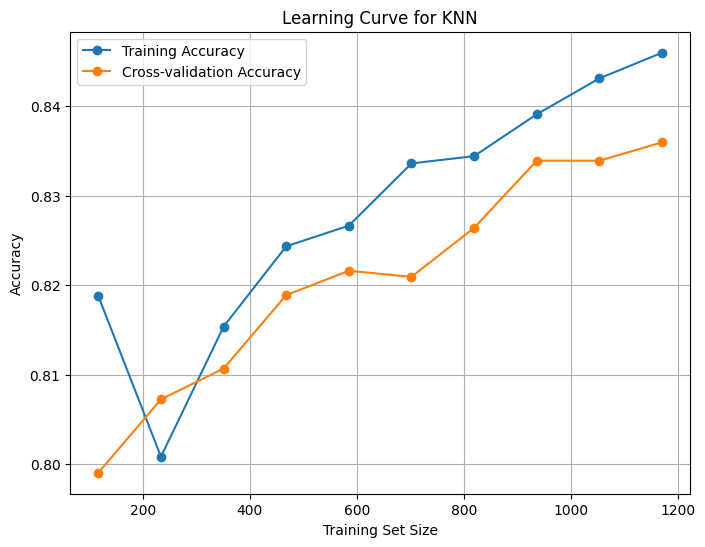

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a pipeline with scaling + PCA + KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # scale features
    ('pca', PCA(n_components=8)),      # reduce to 8 principal components
    ('knn', KNeighborsClassifier())
])

# 2. Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': [10, 15, 20, 25],
    'knn__weights': ['uniform'],  # simpler weights to reduce overfitting
    'knn__metric': ['manhattan', 'euclidean']
}

# 3. Setup GridSearchCV with 5-fold CV
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# 4. Fit on training data
grid_search.fit(X_train, y_train)

# 5. Print best parameters and CV accuracy
print("Best KNN parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# 6. Evaluate on test data
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

# 7. Plot learning curve to check overfitting
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train,
    cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for KNN')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are ready

# Base learners with pipelines if scaling needed
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          max_depth=7, learning_rate=0.1, n_estimators=200, random_state=42)),
    ('mlp', Pipeline([
        ('scaler', StandardScaler()),
        ('mlp_clf', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500,
                                  early_stopping=True, random_state=42))
    ])),
    ('svm', Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(C=1, kernel='rbf', gamma='scale', probability=True, random_state=42))
    ]))
]

# Meta learner
meta_learner = LogisticRegression(max_iter=500, random_state=42)

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train stacking model
stacking_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = stacking_clf.predict(X_test)

print(f"Stacking Ensemble Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Stacking Ensemble Test Accuracy: 0.8661

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       171
           1       0.88      0.87      0.87       195

    accuracy                           0.87       366
   macro avg       0.87      0.87      0.87       366
weighted avg       0.87      0.87      0.87       366



In [ ]:
df.describe()

,age,gender,pluse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,cardiovascular_disease,stroke,output,pulse_pressure,bmi_glucose,age_glucose
count,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000,1829.000000
mean,47.488792,0.399672,75.229087,132.244943,82.396391,186.865894,154.844813,56.829798,23.954692,0.256424,0.059595,0.025697,0.531985,49.848551,4565.588998,8814.437223
std,14.262639,0.489965,10.696351,21.006463,11.306154,96.022004,11.387424,10.599568,5.333929,0.436778,0.236800,0.158273,0.499112,15.438327,2759.323397,5330.146548
min,7.000000,0.000000,39.000000,84.000000,47.000000,7.740000,94.792800,19.000000,8.242689,0.000000,0.000000,0.000000,0.000000,11.000000,144.480000,193.500000
25%,36.000000,0.000000,69.000000,120.000000,77.000000,117.000000,152.000000,50.000000,20.556079,0.000000,0.000000,0.000000,0.000000,40.000000,2577.123967,5212.800000
50%,48.000000,0.000000,74.000000,126.000000,80.000000,153.000000,155.448000,56.000000,23.026316,0.000000,0.000000,0.000000,1.000000,46.000000,3556.994797,7421.760000
75%,58.000000,1.000000,80.000000,143.000000,89.000000,240.000000,163.000000,63.000000,26.284467,1.000000,0.000000,0.000000,1.000000,58.000000,6016.140746,10971.000000
max,102.000000,1.000000,131.000000,231.000000,119.000000,846.000000,195.000000,100.000000,55.437761,1.000000,1.000000,1.000000,1.000000,130.000000,20542.986726,49914.000000


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 6, 8, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_samples': [0.5, 0.7, None],
    'class_weight': ['balanced', None]
}

search = RandomizedSearchCV(rf, param_dist, cv=5, scoring='accuracy', n_iter=20, random_state=42)
search.fit(X_train, y_train)
best_params = search.best_params_
print(search)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    max_depth=8,
                                                    max_samples=0.7,
                                                    min_samples_leaf=10,
                                                    n_estimators=300, n_jobs=-1,
                                                    oob_score=True,
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [None, 6, 8, 10],
                                        'max_samples': [0.5, 0.7, None],
                                        'min_samples_leaf': [1, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy')


In [ ]:
!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTEENN
import joblib

# Load the dataset
df = pd.read_csv("DiabetesDataSurveyBy_RIR.csv")

# Encode 'gender'
gender_encoder = LabelEncoder()
df['gender'] = gender_encoder.fit_transform(df['gender'])

# Use all original features
X = df.drop(columns=['output'])
y = df['output']

# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Conservative Random Forest (tight train-test gap)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=10,
    max_samples=0.7,
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf.fit(X_train, y_train)

# Predict on train and test sets
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluate
print("Train Accuracy:", round(accuracy_score(y_train, train_preds) * 100, 2), "%")
print("Test Accuracy:", round(accuracy_score(y_test, test_preds) * 100, 2), "%")
print("OOB Score:", round(rf.oob_score_ * 100, 2), "%")

print("\nClassification Report:")
print(classification_report(y_test, test_preds))

Train Accuracy: 98.0 %
Test Accuracy: 97.78 %
OOB Score: 97.44 %

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       107
           1       0.96      1.00      0.98       118

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225



In [ ]:
print(rf.feature_names_in_)


['age' 'gender' 'pluse_rate' 'systolic_bp' 'diastolic_bp' 'glucose'
 'height' 'weight' 'bmi' 'family_diabetes' 'cardiovascular_disease'
 'stroke']


In [ ]:
import joblib

# Save your trained model
joblib.dump(rf, "diabetes_rf_model.pkl")
print("Model saved as diabetes_rf_model.pkl")


Model saved as diabetes_rf_model.pkl


In [ ]:
import pandas as pd
import joblib

def get_user_input():
    # Base features
    age = int(input("Age: "))
    gender = int(input("Gender (0 = Female, 1 = Male): "))
    pluse_rate = int(input("Pluse Rate: "))
    systolic_bp = int(input("Systolic BP: "))
    diastolic_bp = int(input("Diastolic BP: "))
    glucose = float(input("Glucose Level: "))
    height = float(input("Height (cm): "))
    weight = float(input("Weight (kg): "))
    bmi = float(input("BMI: "))
    family_diabetes = int(input("Family Diabetes (0/1): "))
    cardiovascular_disease = int(input("Cardiovascular Disease (0/1): "))
    stroke = int(input("Stroke (0/1): "))

    # Derived features
    pulse_pressure = systolic_bp - diastolic_bp
    bmi_glucose = bmi * glucose
    age_glucose = age * glucose

    # Return full feature set
    return pd.DataFrame([{
        'age': age,
        'gender': gender,
        'pluse_rate': pluse_rate,
        'systolic_bp': systolic_bp,
        'diastolic_bp': diastolic_bp,
        'glucose': glucose,
        'height': height,
        'weight': weight,
        'bmi': bmi,
        'family_diabetes': family_diabetes,
        'cardiovascular_disease': cardiovascular_disease,
        'stroke': stroke,

    }])

# Load your trained model
model = joblib.load("diabetes_rf_model.pkl")

# Get input and predict
user_df = get_user_input()
prediction = model.predict(user_df)[0]

print("\nPrediction:", "Diabetic" if prediction == 1 else "Not Diabetic")


Age: 45
Gender (0 = Female, 1 = Male): 1
Pluse Rate: 84
Systolic BP: 120
Diastolic BP: 80
Glucose Level: 324
Height (cm): 156
Weight (kg): 51
BMI: 34.32
Family Diabetes (0/1): 0
Cardiovascular Disease (0/1): 1
Stroke (0/1): 0

Prediction: Diabetic


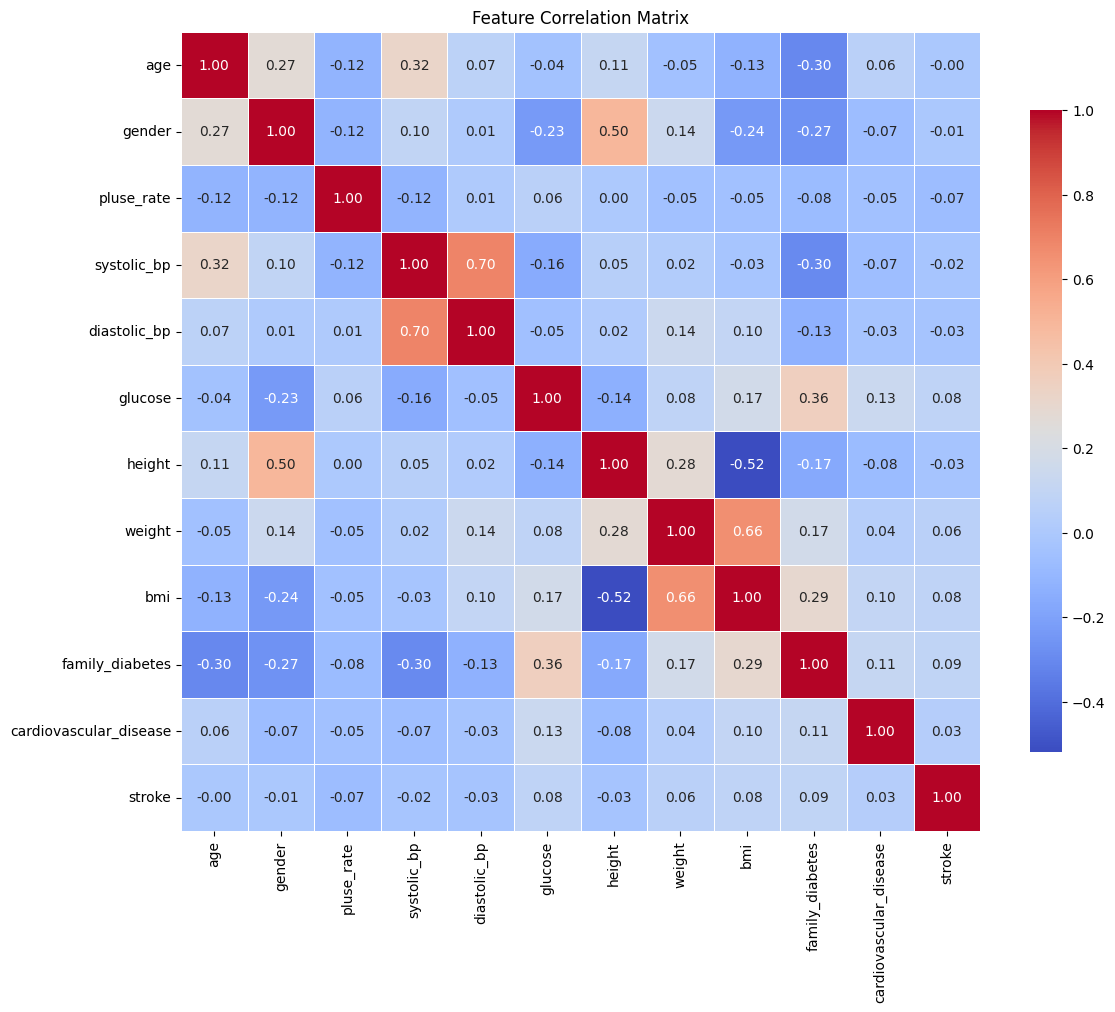

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix (excluding the target 'output' if present)
corr_matrix = df.drop(columns=['output'], errors='ignore').corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)

plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


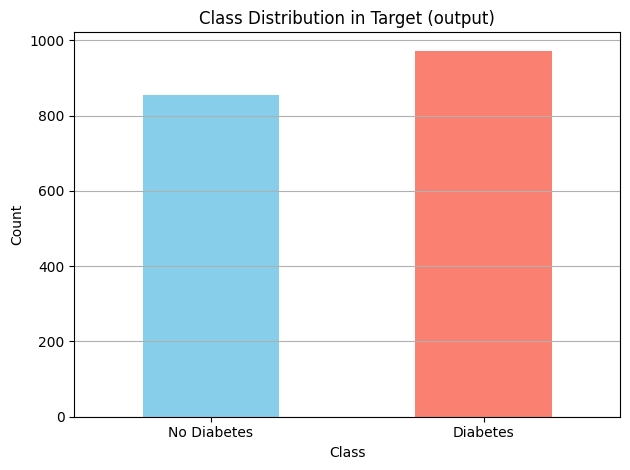

In [ ]:
# Bar chart of the 'output' class
df['output'].value_counts().sort_index().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Target (output)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


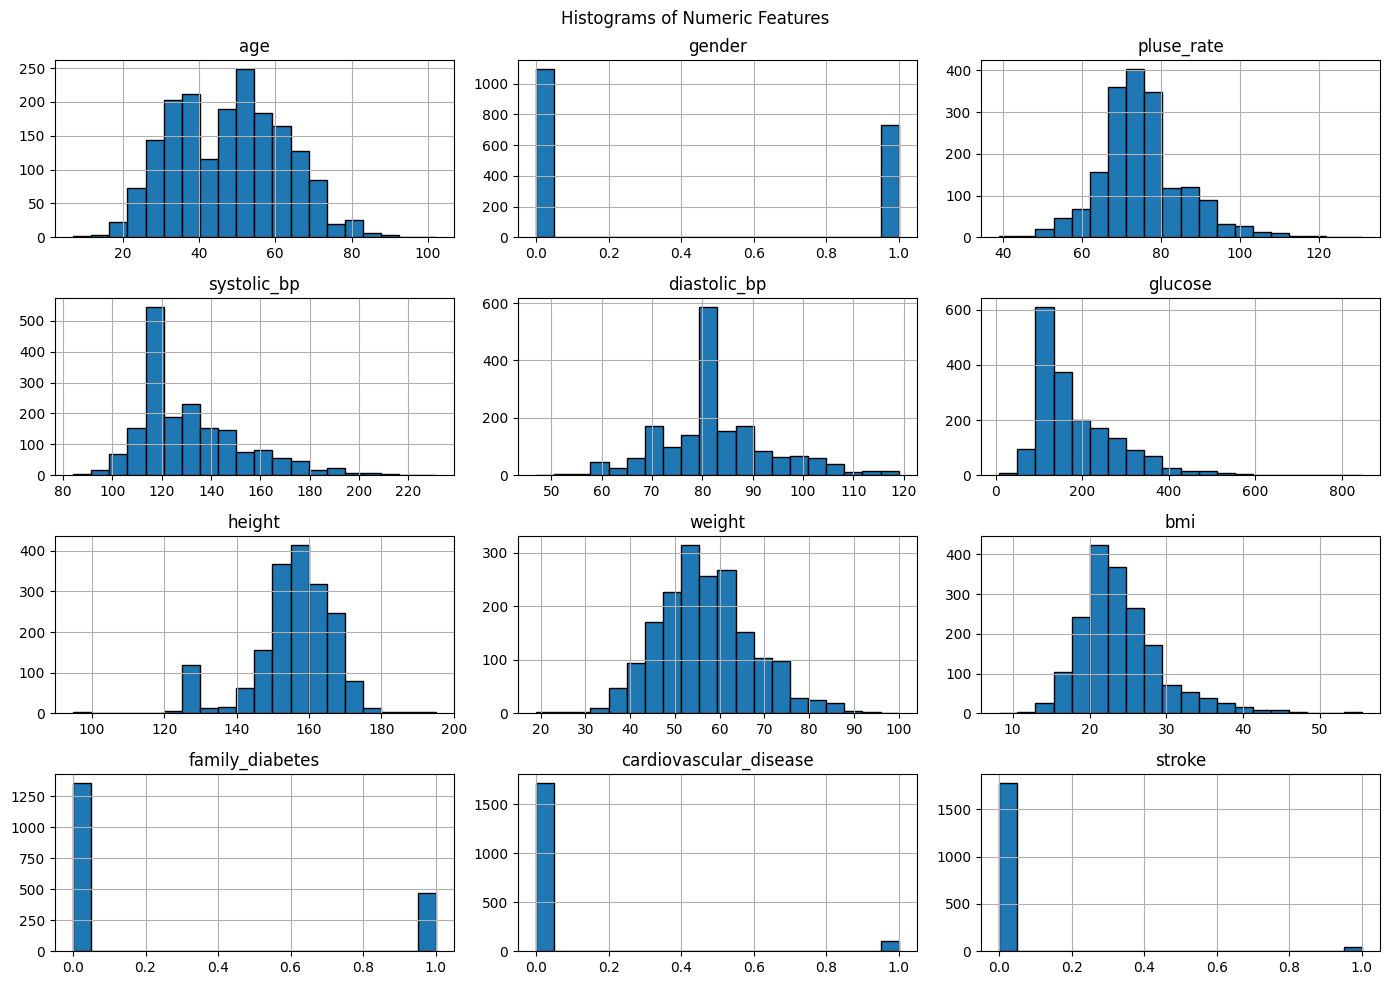

In [ ]:
import matplotlib.pyplot as plt

# Histograms for all numeric columns except target
df.drop(columns=['output'], errors='ignore').hist(bins=20, figsize=(14, 10), edgecolor='black')
plt.suptitle('Histograms of Numeric Features')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

# === ASSUMED: These variables are already available from your previous code ===
# y_pred       -> from XGBoost (booster.predict)
# grid_svm     -> trained SVM GridSearchCV
# mlp_pipeline -> trained MLP pipeline
# grid_search  -> trained KNN GridSearchCV
# stacking_clf -> trained StackingClassifier
# y_test       -> test labels
# X_test       -> test features with engineered columns

# === Compute predictions ===
y_pred_xgb    = y_pred
y_pred_svm    = grid_svm.predict(X_test)
y_pred_mlp    = mlp_pipeline.predict(X_test)
y_pred_knn    = grid_search.predict(X_test)
y_pred_stack  = stacking_clf.predict(X_test)

# === Compute accuracy ===
accuracy_results = {
    "XGBoost": accuracy_score(y_test, y_pred_xgb),
    "SVM": accuracy_score(y_test, y_pred_svm),
    "MLP": accuracy_score(y_test, y_pred_mlp),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "Stacking": accuracy_score(y_test, y_pred_stack)
}

# === Create DataFrame for plotting ===
accuracy_df = pd.DataFrame(
    list(accuracy_results.items()), columns=["Model", "Accuracy"]
).sort_values(by="Accuracy", ascending=True)

# === Plotting ===
plt.figure(figsize=(8, 5))
bars = plt.barh(accuracy_df["Model"], accuracy_df["Accuracy"], color='skyblue')
plt.xlabel("Accuracy Score")
plt.title("Test Accuracy Comparison ")
plt.xlim(0, 1)

# Add accuracy values next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f"{width:.3f}", va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- age_glucose
- bmi_glucose
- pulse_pressure


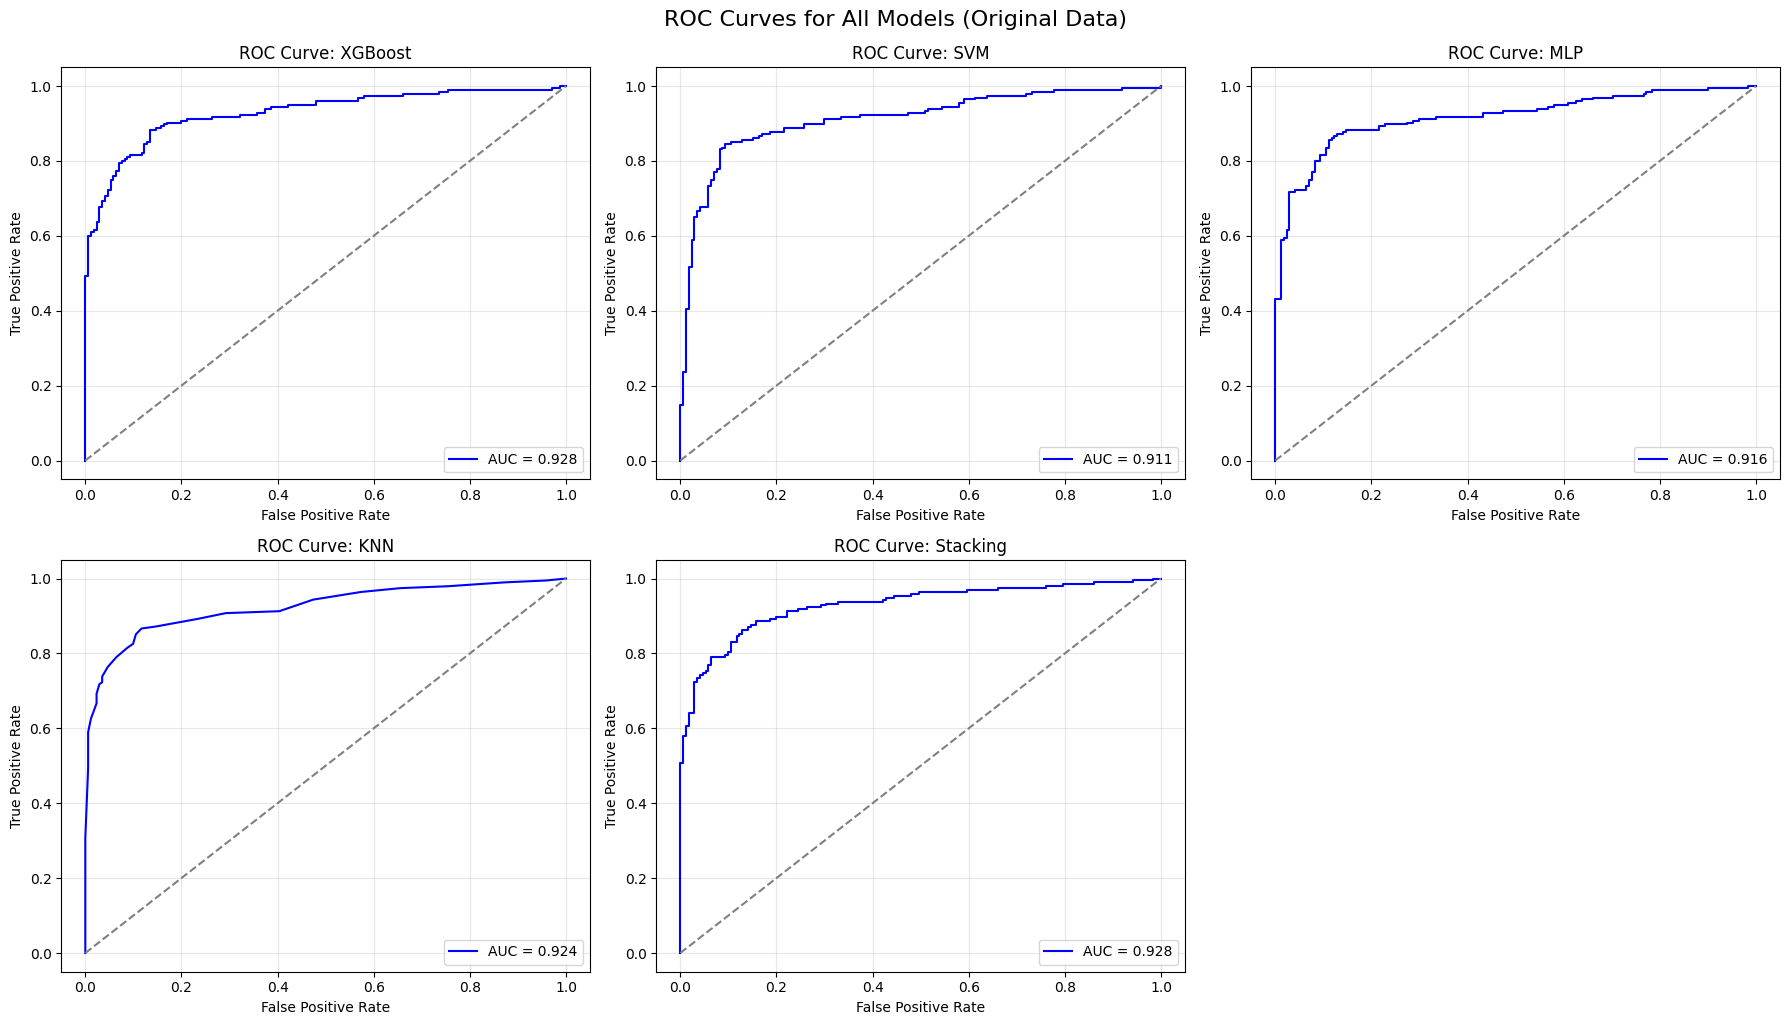

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# === Predict probabilities ===
y_proba_xgb   = booster.predict(xgb.DMatrix(X_test))                 # XGBoost
y_proba_svm   = grid_svm.predict_proba(X_test)[:, 1]                 # SVM
y_proba_mlp   = mlp_pipeline.predict_proba(X_test)[:, 1]             # MLP
y_proba_knn   = grid_search.predict_proba(X_test)[:, 1]              # KNN
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]             # Stacking

# === Create list of models ===
model_outputs = [
    ("XGBoost", y_test, y_proba_xgb),
    ("SVM", y_test, y_proba_svm),
    ("MLP", y_test, y_proba_mlp),
    ("KNN", y_test, y_proba_knn),
    ("Stacking", y_test, y_proba_stack)
]

# === Plot each ROC in a separate subplot ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (name, y_true, y_proba) in enumerate(model_outputs):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='blue')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[i].set_title(f"ROC Curve: {name}")
    axes[i].set_xlabel("False Positive Rate")
    axes[i].set_ylabel("True Positive Rate")
    axes[i].legend(loc="lower right")
    axes[i].grid(alpha=0.3)

# Hide the empty 6th plot
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle("ROC Curves for All Models (Original Data)", fontsize=16, y=1.02)
plt.show()


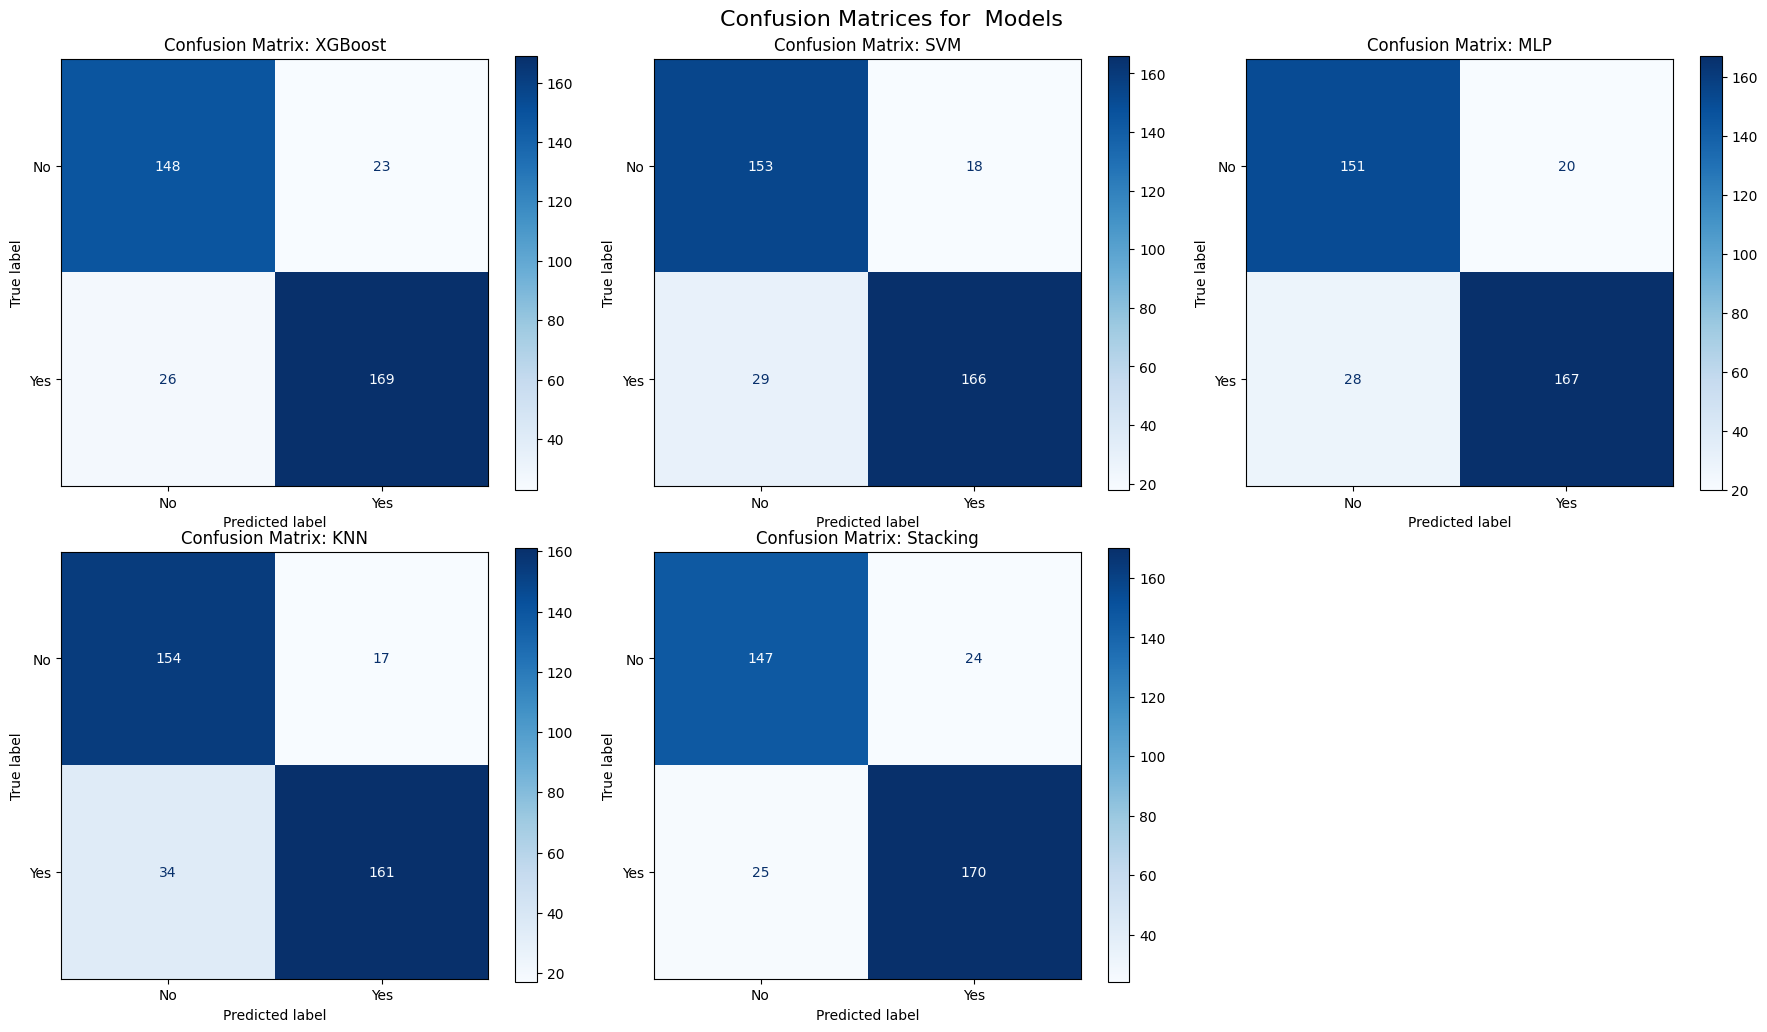

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Predictions for each model ===
y_pred_xgb   = (booster.predict(xgb.DMatrix(X_test)) >= 0.5).astype(int)
y_pred_svm   = grid_svm.predict(X_test)
y_pred_mlp   = mlp_pipeline.predict(X_test)
y_pred_knn   = grid_search.predict(X_test)
y_pred_stack = stacking_clf.predict(X_test)

# === Model predictions dictionary ===
model_preds = {
    "XGBoost": y_pred_xgb,
    "SVM": y_pred_svm,
    "MLP": y_pred_mlp,
    "KNN": y_pred_knn,
    "Stacking": y_pred_stack
}

# === Plot confusion matrices ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (name, y_pred) in enumerate(model_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')
    axes[i].set_title(f"Confusion Matrix: {name}")

# Remove unused subplot (6th one)
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle("Confusion Matrices for  Models ", fontsize=16, y=1.02)
plt.show()



Train Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       428
           1       0.99      0.98      0.98       472

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900

Test Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       107
           1       0.96      1.00      0.98       118

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225

Train ROC AUC: 0.999
Test ROC AUC: 1.000


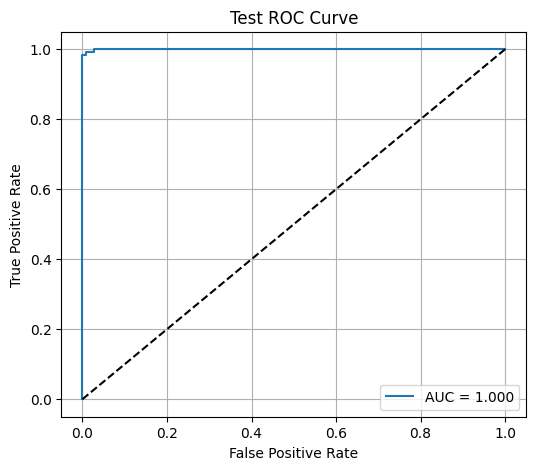

/tmp/ipython-input-27-2440541328.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feat_names[indices], palette="viridis")


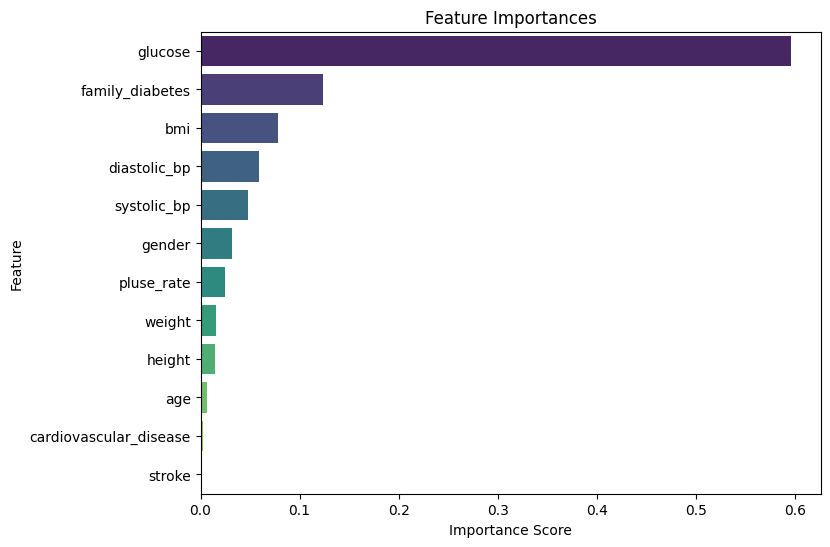

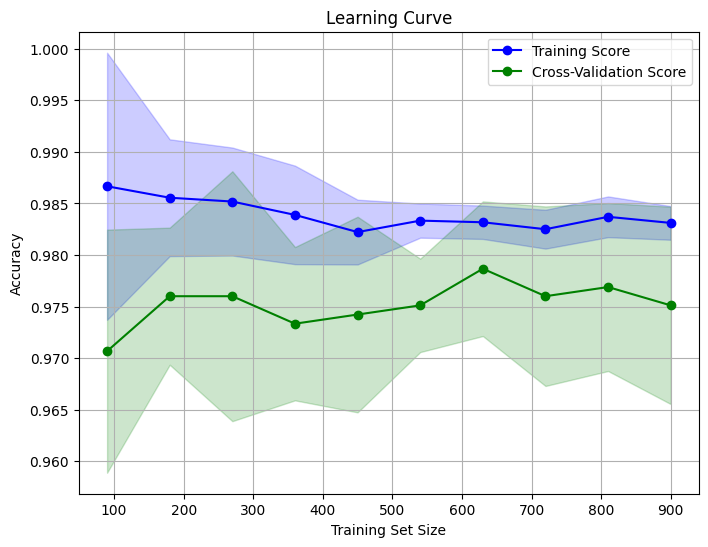


10-Fold CV Accuracy Mean: 0.975
10-Fold CV Accuracy Std: 0.014

20-Fold CV Accuracy Mean: 0.977
20-Fold CV Accuracy Std: 0.023


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_score, learning_curve

# Classification Reports
print("\nTrain Classification Report:\n")
print(classification_report(y_train, train_preds))

print("Test Classification Report:\n")
print(classification_report(y_test, test_preds))

# ROC AUC Scores
train_proba = rf.predict_proba(X_train)[:, 1]
test_proba = rf.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, train_proba)
test_auc = roc_auc_score(y_test, test_proba)

print(f"Train ROC AUC: {train_auc:.3f}")
print(f"Test ROC AUC: {test_auc:.3f}")

# ROC Curve for Test Set
fpr, tpr, thresholds = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importances
importances = rf.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=feat_names[indices], palette="viridis")
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf,
    X=X_resampled,
    y=y_resampled,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.grid(True)
plt.show()




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


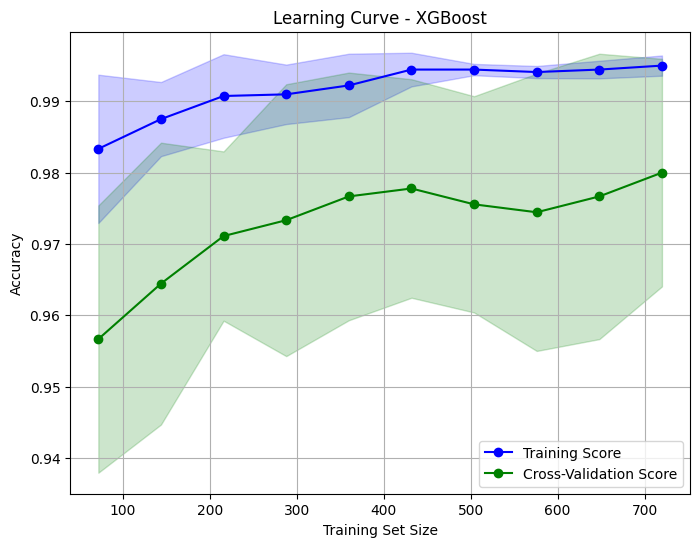

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:31:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/tmp/ipython-input-28-1388864238.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feat_names)[indices], palette="viridis")


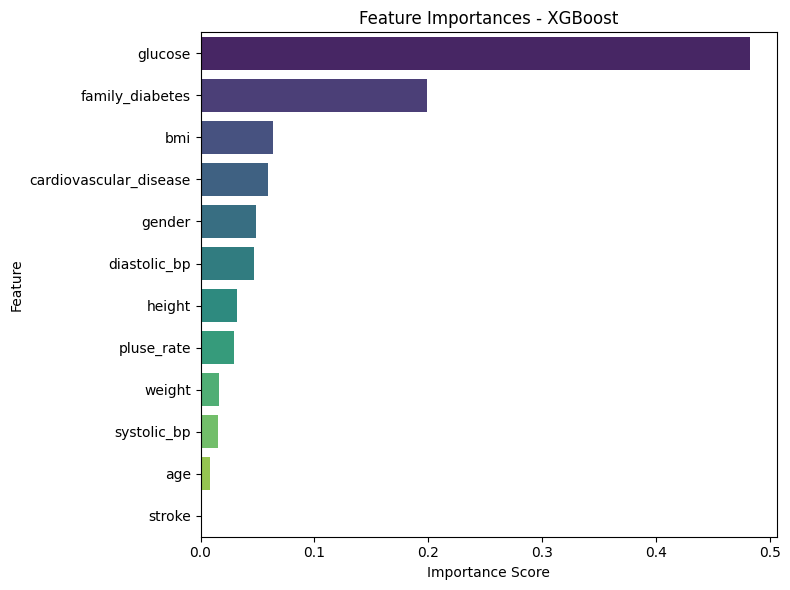


10-Fold CV Accuracy Mean: 0.982
10-Fold CV Accuracy Std: 0.021

20-Fold CV Accuracy Mean: 0.982
20-Fold CV Accuracy Std: 0.026


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, cross_val_score
import pandas as pd

# For learning curve, wrap XGBoost in scikit-learn API
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=3,
    seed=42,
    use_label_encoder=False,
    n_estimators=booster.best_iteration + 1   # Use the best iteration
)

# Fit to all training data for further analysis
xgb_clf.fit(X_train, y_train)

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_clf,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - XGBoost")
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Feature Importances
importances = xgb_clf.feature_importances_
feat_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=np.array(feat_names)[indices], palette="viridis")
plt.title("Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



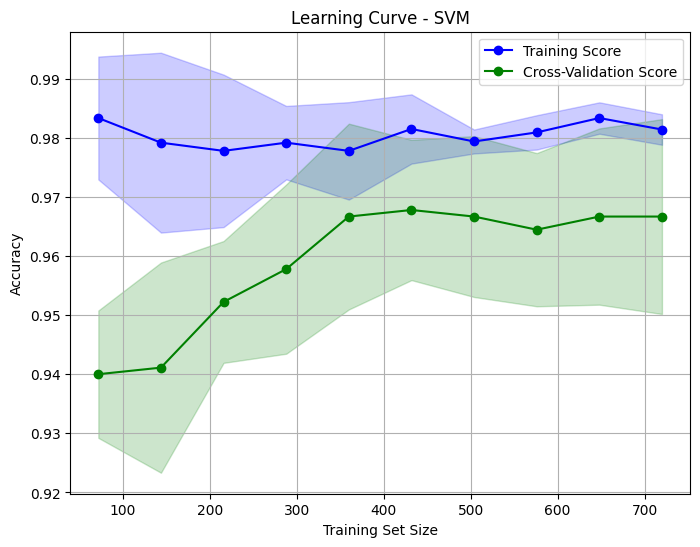


10-Fold CV Accuracy Mean: 0.970
10-Fold CV Accuracy Std: 0.017

20-Fold CV Accuracy Mean: 0.968
20-Fold CV Accuracy Std: 0.024


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, cross_val_score
import numpy as np
import pandas as pd

# For learning curve and cross-validation, use the best estimator
best_svm = grid_svm.best_estimator_

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_svm,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - SVM")
plt.legend(loc='best')
plt.grid(True)
plt.show()





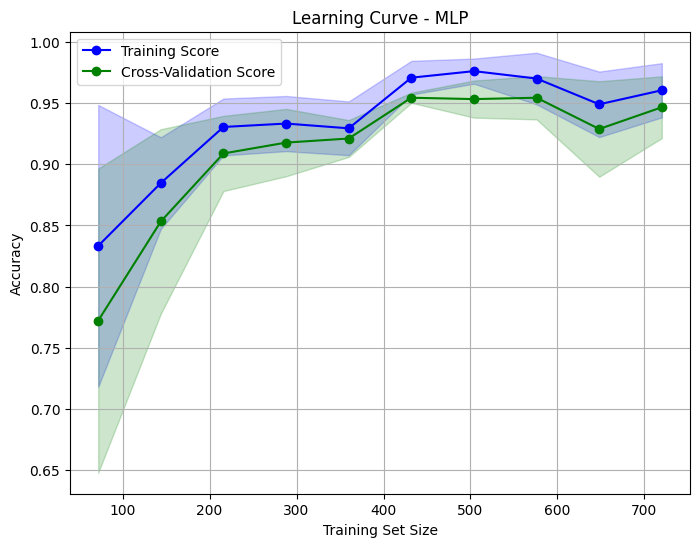


10-Fold CV Accuracy Mean: 0.973
10-Fold CV Accuracy Std: 0.019

20-Fold CV Accuracy Mean: 0.972
20-Fold CV Accuracy Std: 0.026


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=mlp_pipeline,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - MLP")
plt.legend(loc='best')
plt.grid(True)
plt.show()





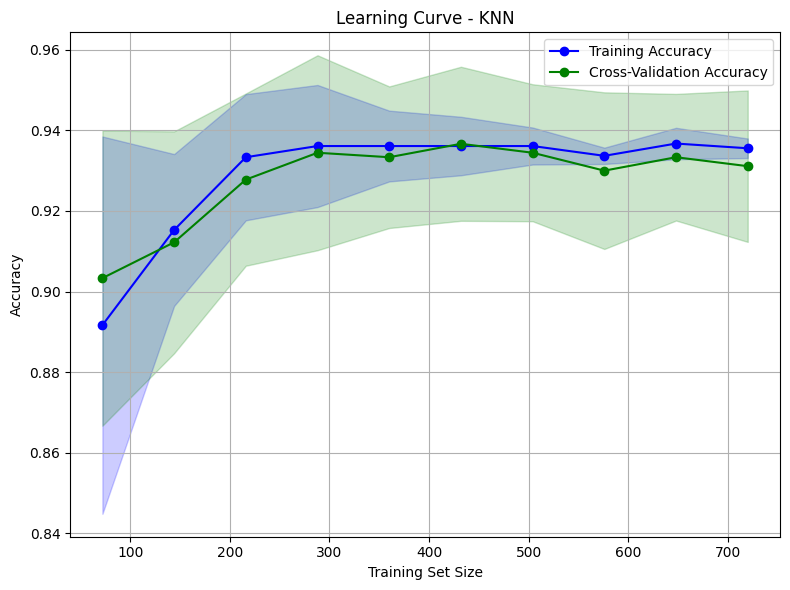


10-Fold CV Accuracy Mean: 0.931
10-Fold CV Accuracy Std: 0.030

20-Fold CV Accuracy Mean: 0.929
20-Fold CV Accuracy Std: 0.037


In [ ]:
from sklearn.model_selection import learning_curve, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Learning Curve (5-fold CV)
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - KNN')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()





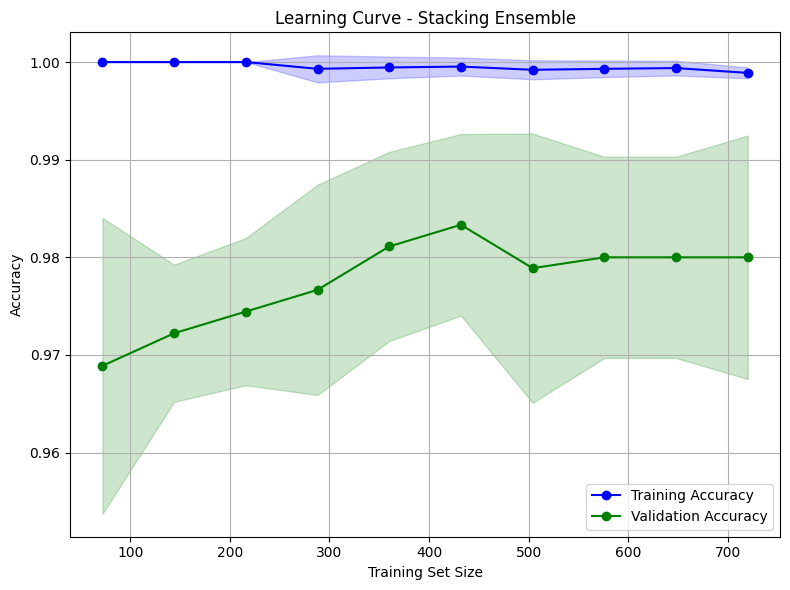


10-Fold CV Accuracy Mean: 0.984
10-Fold CV Accuracy Std: 0.017

20-Fold CV Accuracy Mean: 0.986
20-Fold CV Accuracy Std: 0.023


In [ ]:
from sklearn.model_selection import learning_curve, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Learning Curve (5-fold CV)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=stacking_clf,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Stacking Ensemble')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


